# Furnace Data — Exploratory Data Analysis

Dataset: `cleaned_furnace_data.csv` (470,676 rows × 10 columns)

**Purpose**: Validate cleaned data quality, understand operating dynamics,
and identify any remaining issues before PINN training.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.facecolor'] = 'white'
sns.set_style('whitegrid')

DATA_PATH = Path('.') / 'cleaned_furnace_data.csv'
df = pd.read_csv(DATA_PATH)
print(f'Shape: {df.shape}')
print(f'Columns: {df.columns.tolist()}')
df.head()

Shape: (470676, 10)
Columns: ['Date', 'InletT', 'OutletT', 'DraftP', 'OP_Damper', 'InletFlow', 'ExcessO2', 'FGFlow', 'FGPressure', 'Bridgewall']


,Date,InletT,OutletT,DraftP,OP_Damper,InletFlow,ExcessO2,FGFlow,FGPressure,Bridgewall
0,1,288.976955,320.196560,-3.020254,37.503009,301.418225,4.171483,1045.186457,1.417172,637.501887
1,2,288.783806,320.307488,-3.095533,37.460095,301.318331,4.127733,1051.581609,1.414833,637.701940
2,3,288.600353,320.975382,-3.061606,37.435996,302.035071,4.067477,1056.401786,1.421614,639.184258
3,4,288.824391,321.021937,-2.963447,37.527841,303.449092,4.039101,1058.948099,1.417974,640.589008
4,5,288.863377,320.517106,-2.954726,37.563058,303.673725,4.009887,1056.052007,1.431997,643.209748


## 1. Data Overview

In [2]:
print('Dtypes:')
print(df.dtypes)
print(f'\nNaN count: {df.isnull().sum().sum()}')
print(f'\nDescriptive statistics:')
df.describe().round(3)

Dtypes:
Date            int64
InletT        float64
OutletT       float64
DraftP        float64
OP_Damper     float64
InletFlow     float64
ExcessO2      float64
FGFlow        float64
FGPressure    float64
Bridgewall    float64
dtype: object

NaN count: 0

Descriptive statistics:


,Date,InletT,OutletT,DraftP,OP_Damper,InletFlow,ExcessO2,FGFlow,FGPressure,Bridgewall
count,470676.000,470676.000,470676.000,470676.000,470676.000,470676.000,470676.000,470676.000,470676.000,470676.000
mean,262203.556,288.074,323.780,-4.396,54.555,368.437,3.748,1397.997,1.365,658.047
std,148513.329,6.671,5.073,1.894,5.264,42.829,0.790,208.891,0.266,27.450
min,1.000,263.892,304.062,-10.778,36.018,245.313,0.980,720.955,0.544,556.707
25%,136459.750,285.240,322.445,-5.530,52.300,342.555,3.221,1275.146,1.154,642.406
50%,259629.500,289.018,325.083,-4.190,55.000,375.059,3.627,1412.736,1.339,661.182
75%,393959.250,292.428,326.983,-3.037,58.000,399.729,4.219,1543.680,1.551,678.042
max,525600.000,304.966,335.238,1.564,67.500,442.404,6.677,1976.582,2.184,723.175


## 2. Full-Year Time Series

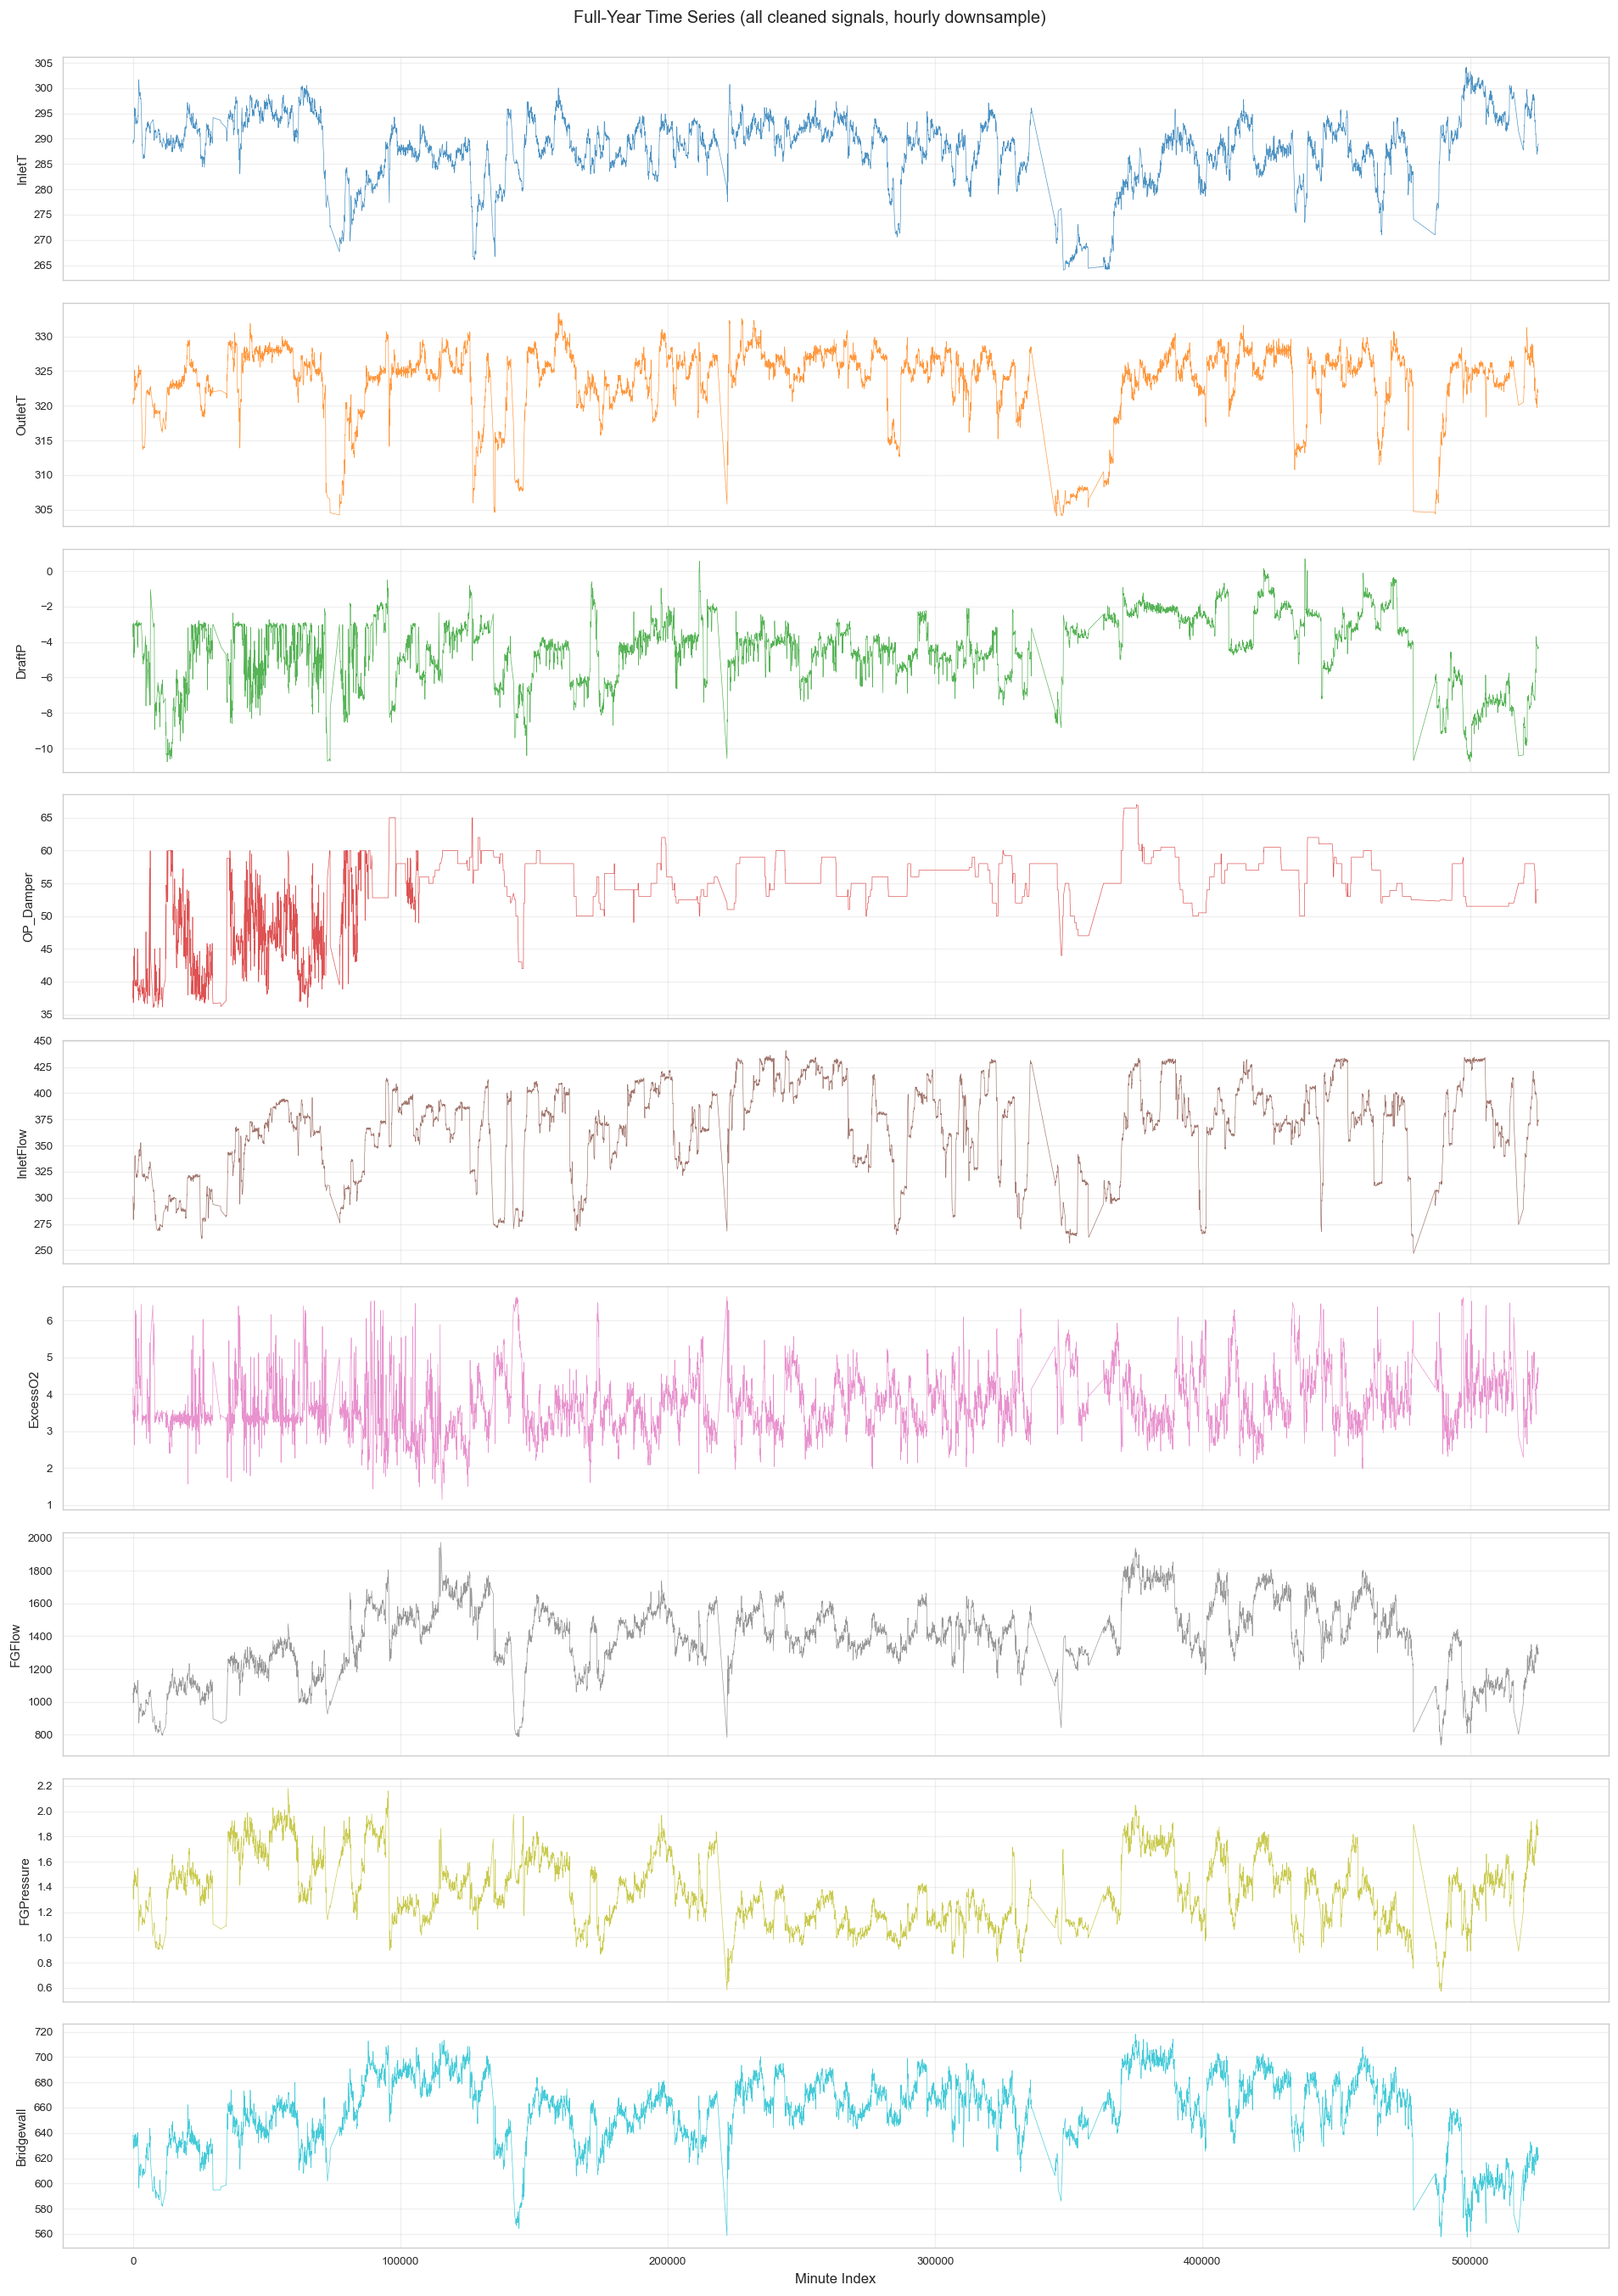

In [3]:
numeric_cols = [c for c in df.columns if c != 'Date']
n_cols = len(numeric_cols)

fig, axes = plt.subplots(n_cols, 1, figsize=(16, 2.5 * n_cols), sharex=True)

colors = plt.cm.tab10(np.linspace(0, 1, n_cols))

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    # Downsample for plotting (every 60th point = ~hourly)
    x = df['Date'].values[::60]
    y = df[col].values[::60]
    ax.plot(x, y, color=colors[i], linewidth=0.4, alpha=0.8)
    ax.set_ylabel(col, fontsize=9)
    ax.tick_params(labelsize=8)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Minute Index', fontsize=10)
fig.suptitle('Full-Year Time Series (all cleaned signals, hourly downsample)', fontsize=12, y=1.0)
plt.tight_layout()
plt.savefig('plots/eda_full_year_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Zoomed 1-Week Window (normal operation)

Zoom window: 10080 minutes from the longest contiguous block (92,431 min)


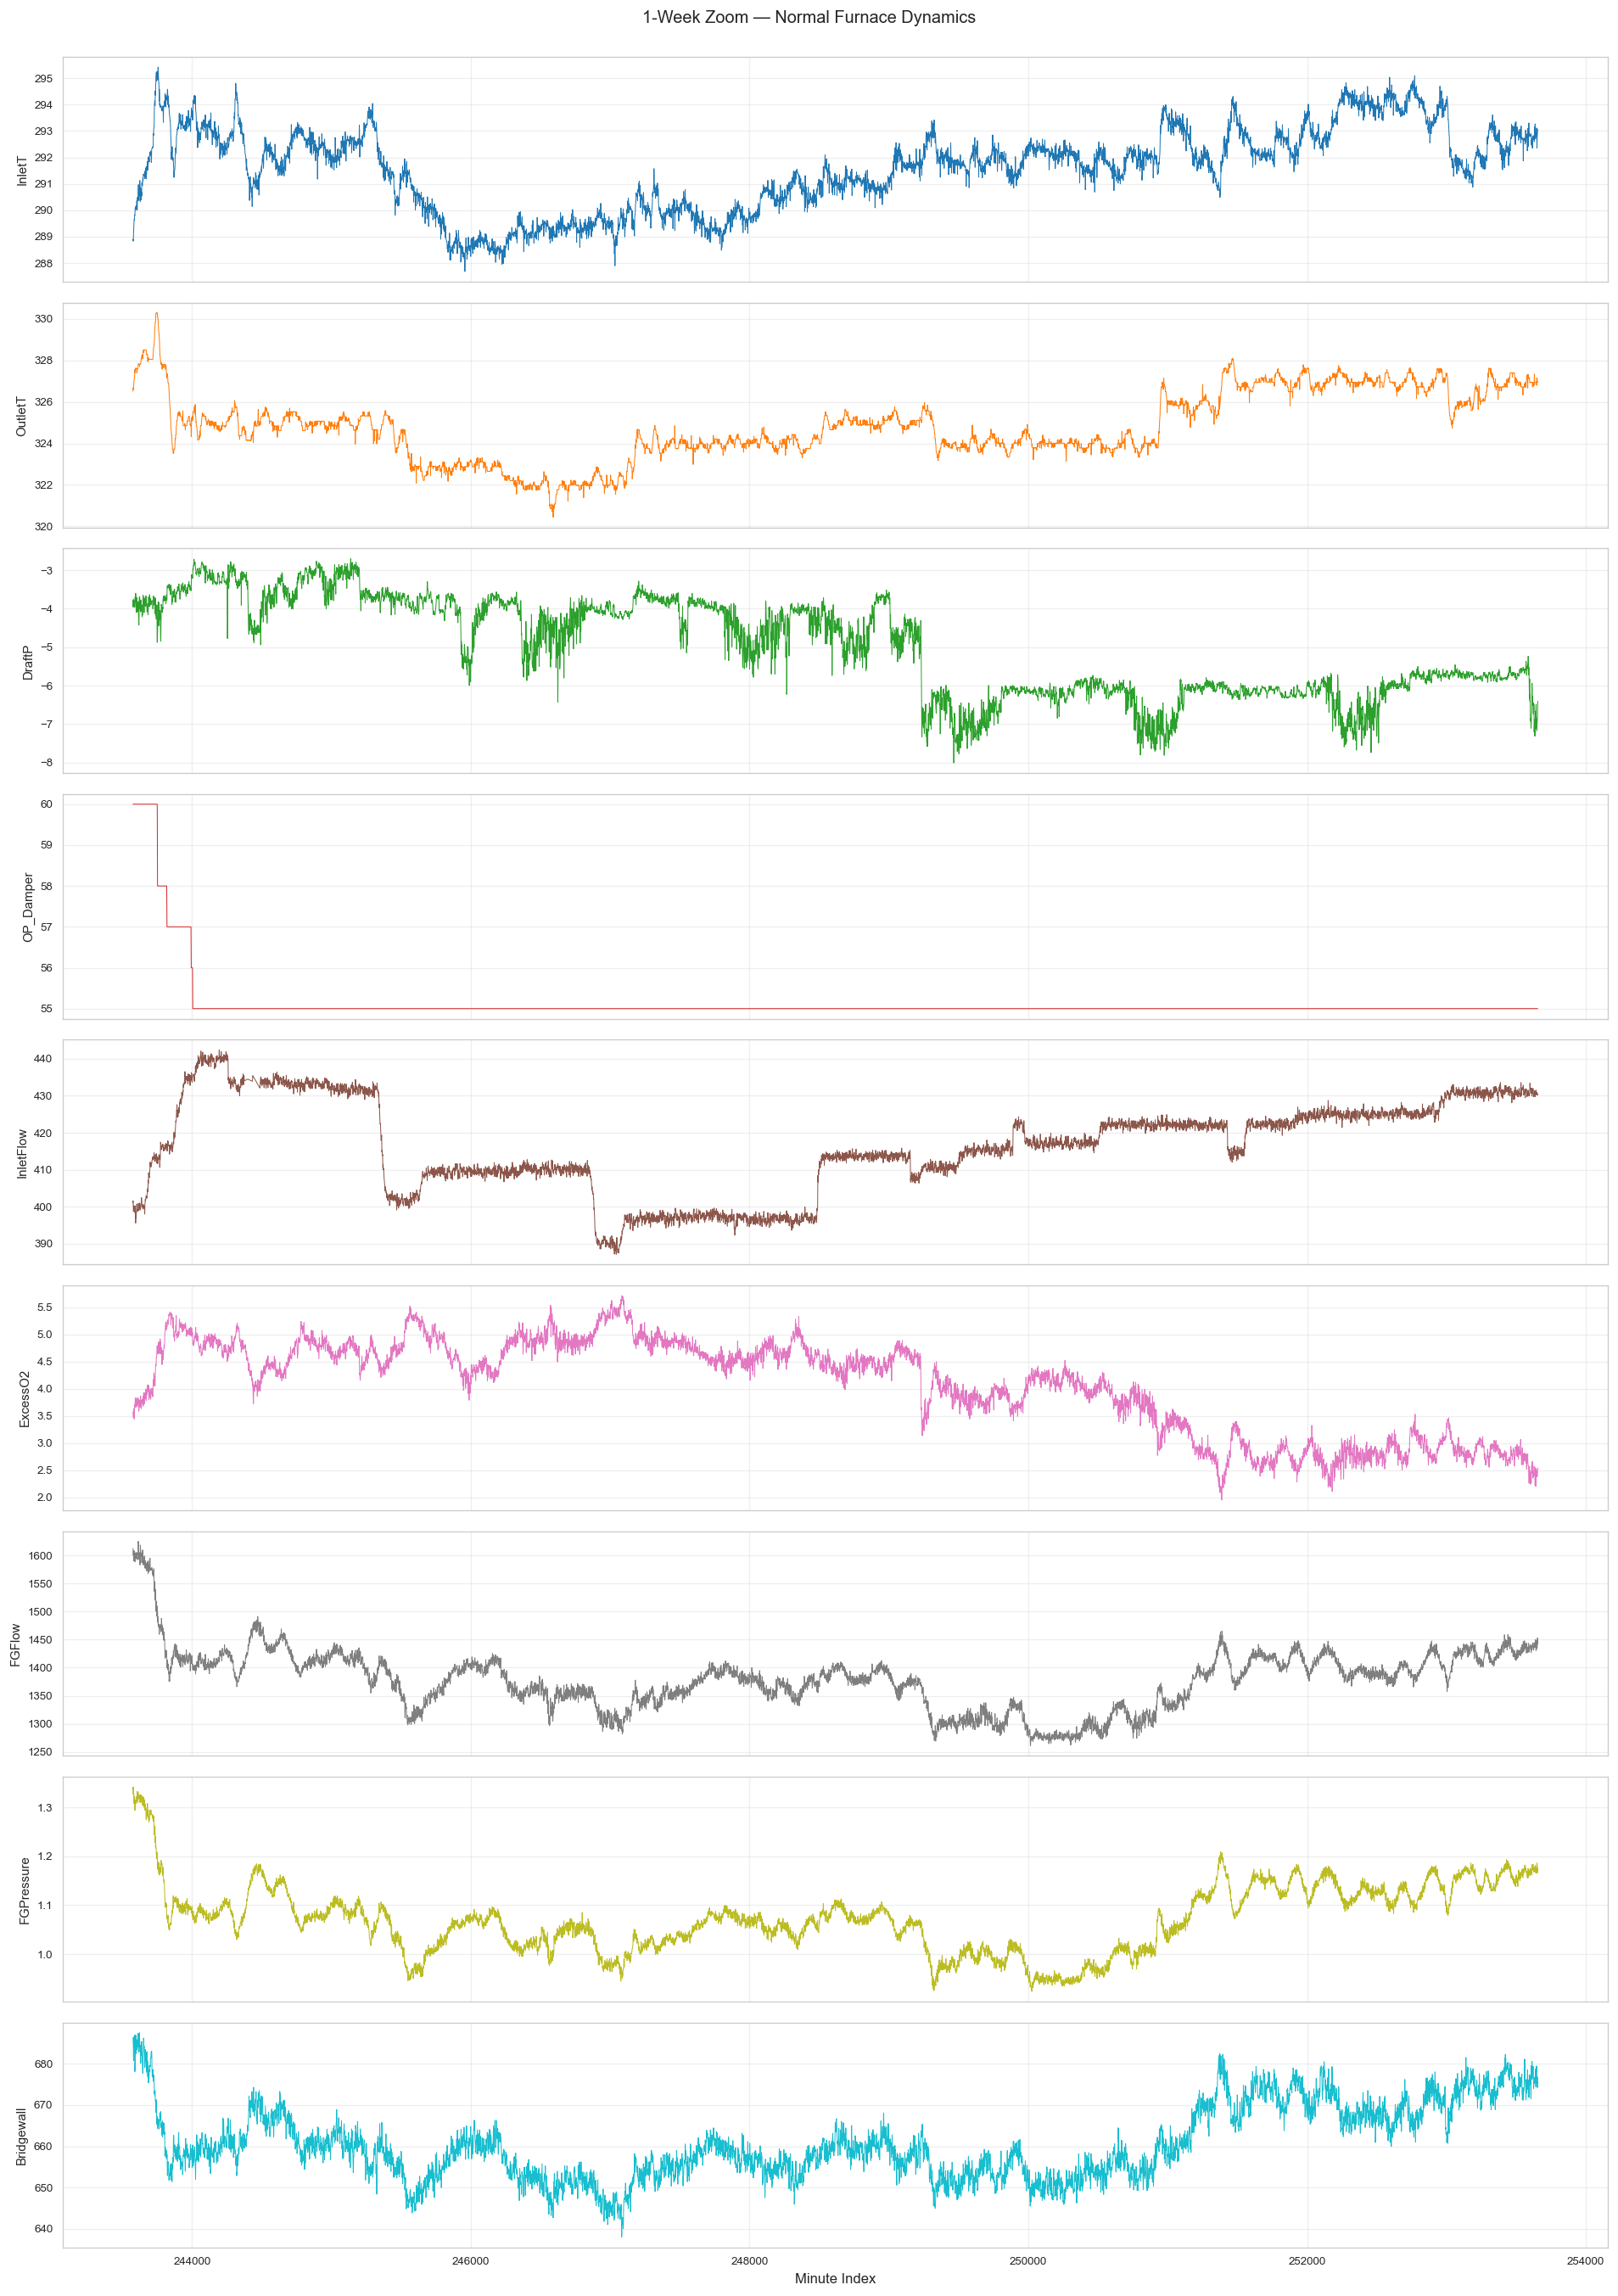

In [4]:
# Find a contiguous block of at least 7 days (10080 min)
date_diff = df['Date'].diff()
block_break = date_diff > 1
block_id = block_break.cumsum()
block_sizes = block_id.value_counts()

# Pick the longest block
longest_block_id = block_sizes.idxmax()
longest_mask = block_id == longest_block_id
df_zoom = df[longest_mask].head(10080)  # 1 week

print(f'Zoom window: {len(df_zoom)} minutes from the longest contiguous block ({block_sizes.max():,} min)')

fig, axes = plt.subplots(n_cols, 1, figsize=(16, 2.5 * n_cols), sharex=True)

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    ax.plot(df_zoom['Date'].values, df_zoom[col].values,
            color=colors[i], linewidth=0.6)
    ax.set_ylabel(col, fontsize=9)
    ax.tick_params(labelsize=8)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Minute Index', fontsize=10)
fig.suptitle('1-Week Zoom — Normal Furnace Dynamics', fontsize=12, y=1.0)
plt.tight_layout()
plt.savefig('plots/eda_1week_zoom.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Correlation Heatmap

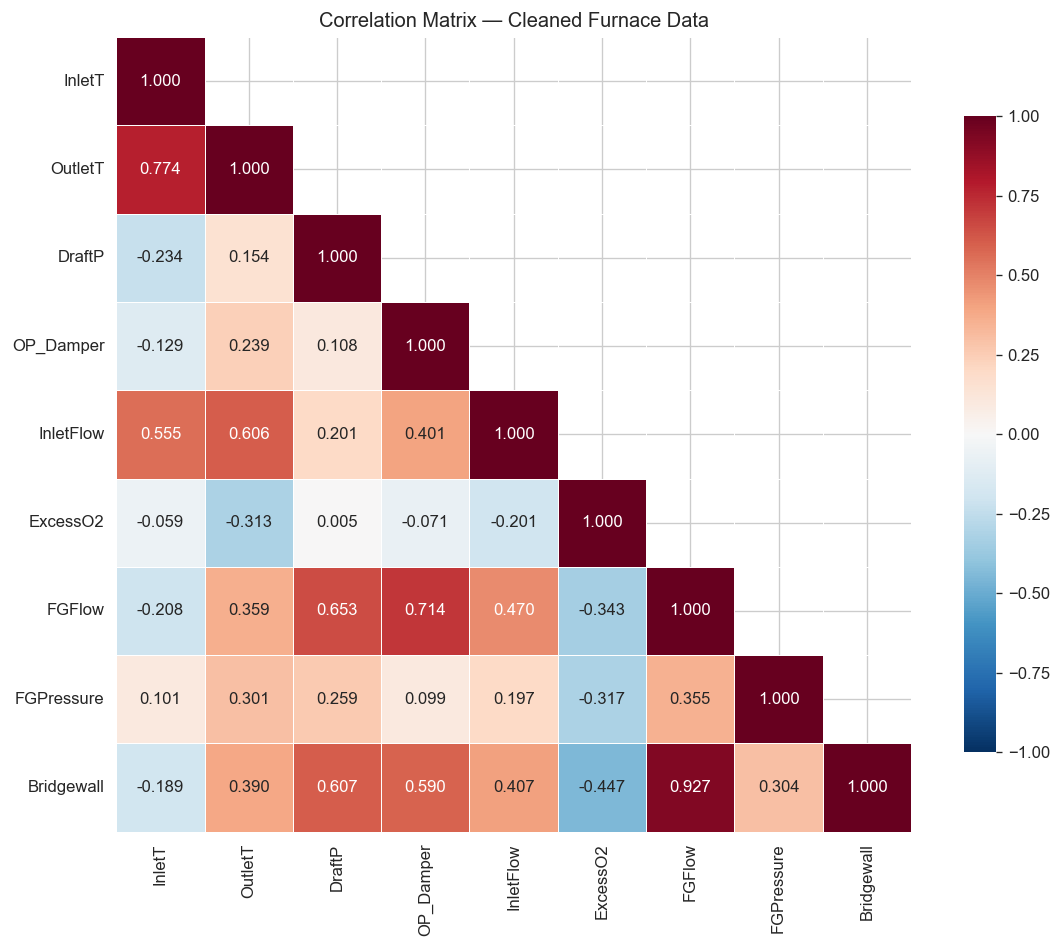


Strong correlations (|r| > 0.7):
          InletT ↔ OutletT         r = 0.774
       OP_Damper ↔ FGFlow          r = 0.714
          FGFlow ↔ Bridgewall      r = 0.927


In [5]:
corr = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(
    corr, mask=mask, annot=True, fmt='.3f', cmap='RdBu_r',
    center=0, vmin=-1, vmax=1, ax=ax,
    linewidths=0.5, square=True, cbar_kws={'shrink': 0.8}
)
ax.set_title('Correlation Matrix — Cleaned Furnace Data', fontsize=12)
plt.tight_layout()
plt.savefig('plots/eda_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nStrong correlations (|r| > 0.7):')
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        r = corr.iloc[i, j]
        if abs(r) > 0.7:
            print(f'  {corr.columns[i]:>14} ↔ {corr.columns[j]:<14}  r = {r:.3f}')

## 5. Distribution Histograms

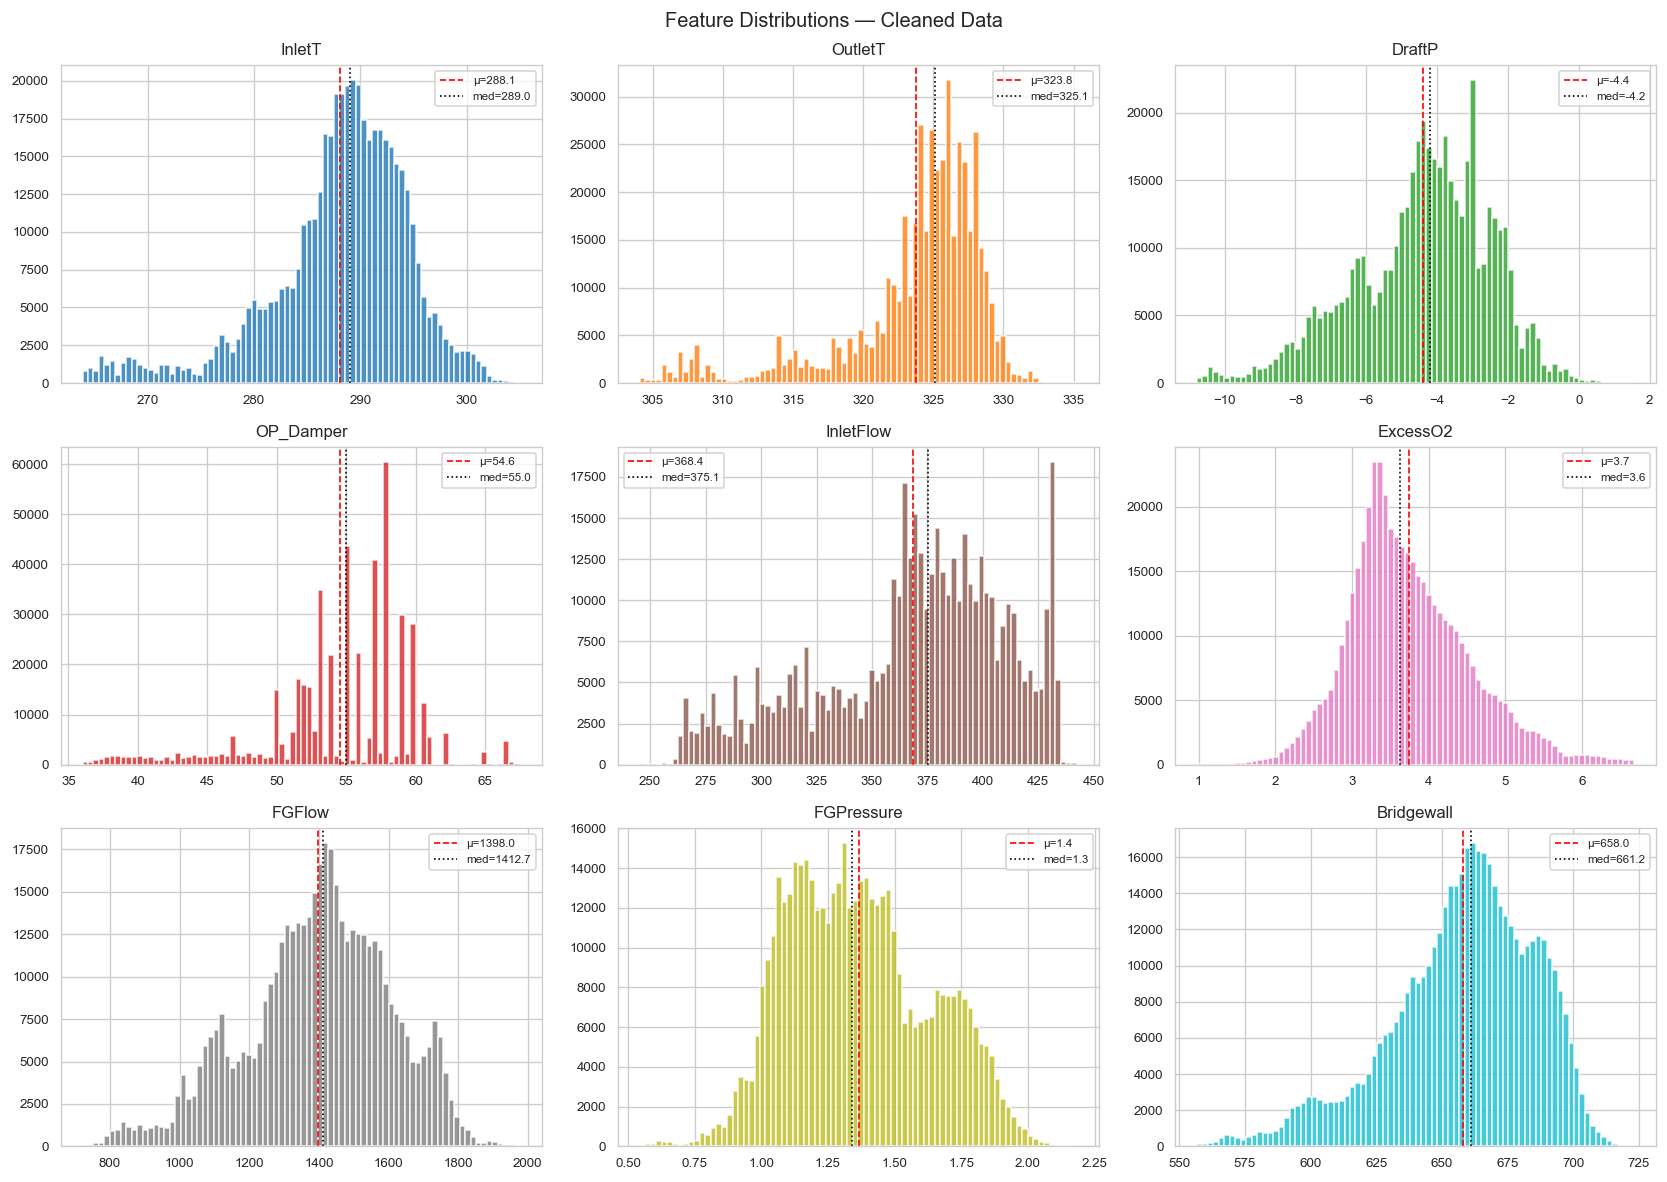

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    vals = df[col].dropna()
    ax.hist(vals, bins=80, color=colors[i], edgecolor='white', alpha=0.8)
    ax.axvline(vals.mean(), color='red', linestyle='--', linewidth=1, label=f'μ={vals.mean():.1f}')
    ax.axvline(vals.median(), color='black', linestyle=':', linewidth=1, label=f'med={vals.median():.1f}')
    ax.set_title(col, fontsize=10)
    ax.legend(fontsize=7)
    ax.tick_params(labelsize=8)

# Hide unused subplots
for j in range(len(numeric_cols), len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Feature Distributions — Cleaned Data', fontsize=12)
plt.tight_layout()
plt.savefig('plots/eda_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Rolling Statistics (1-hour window)

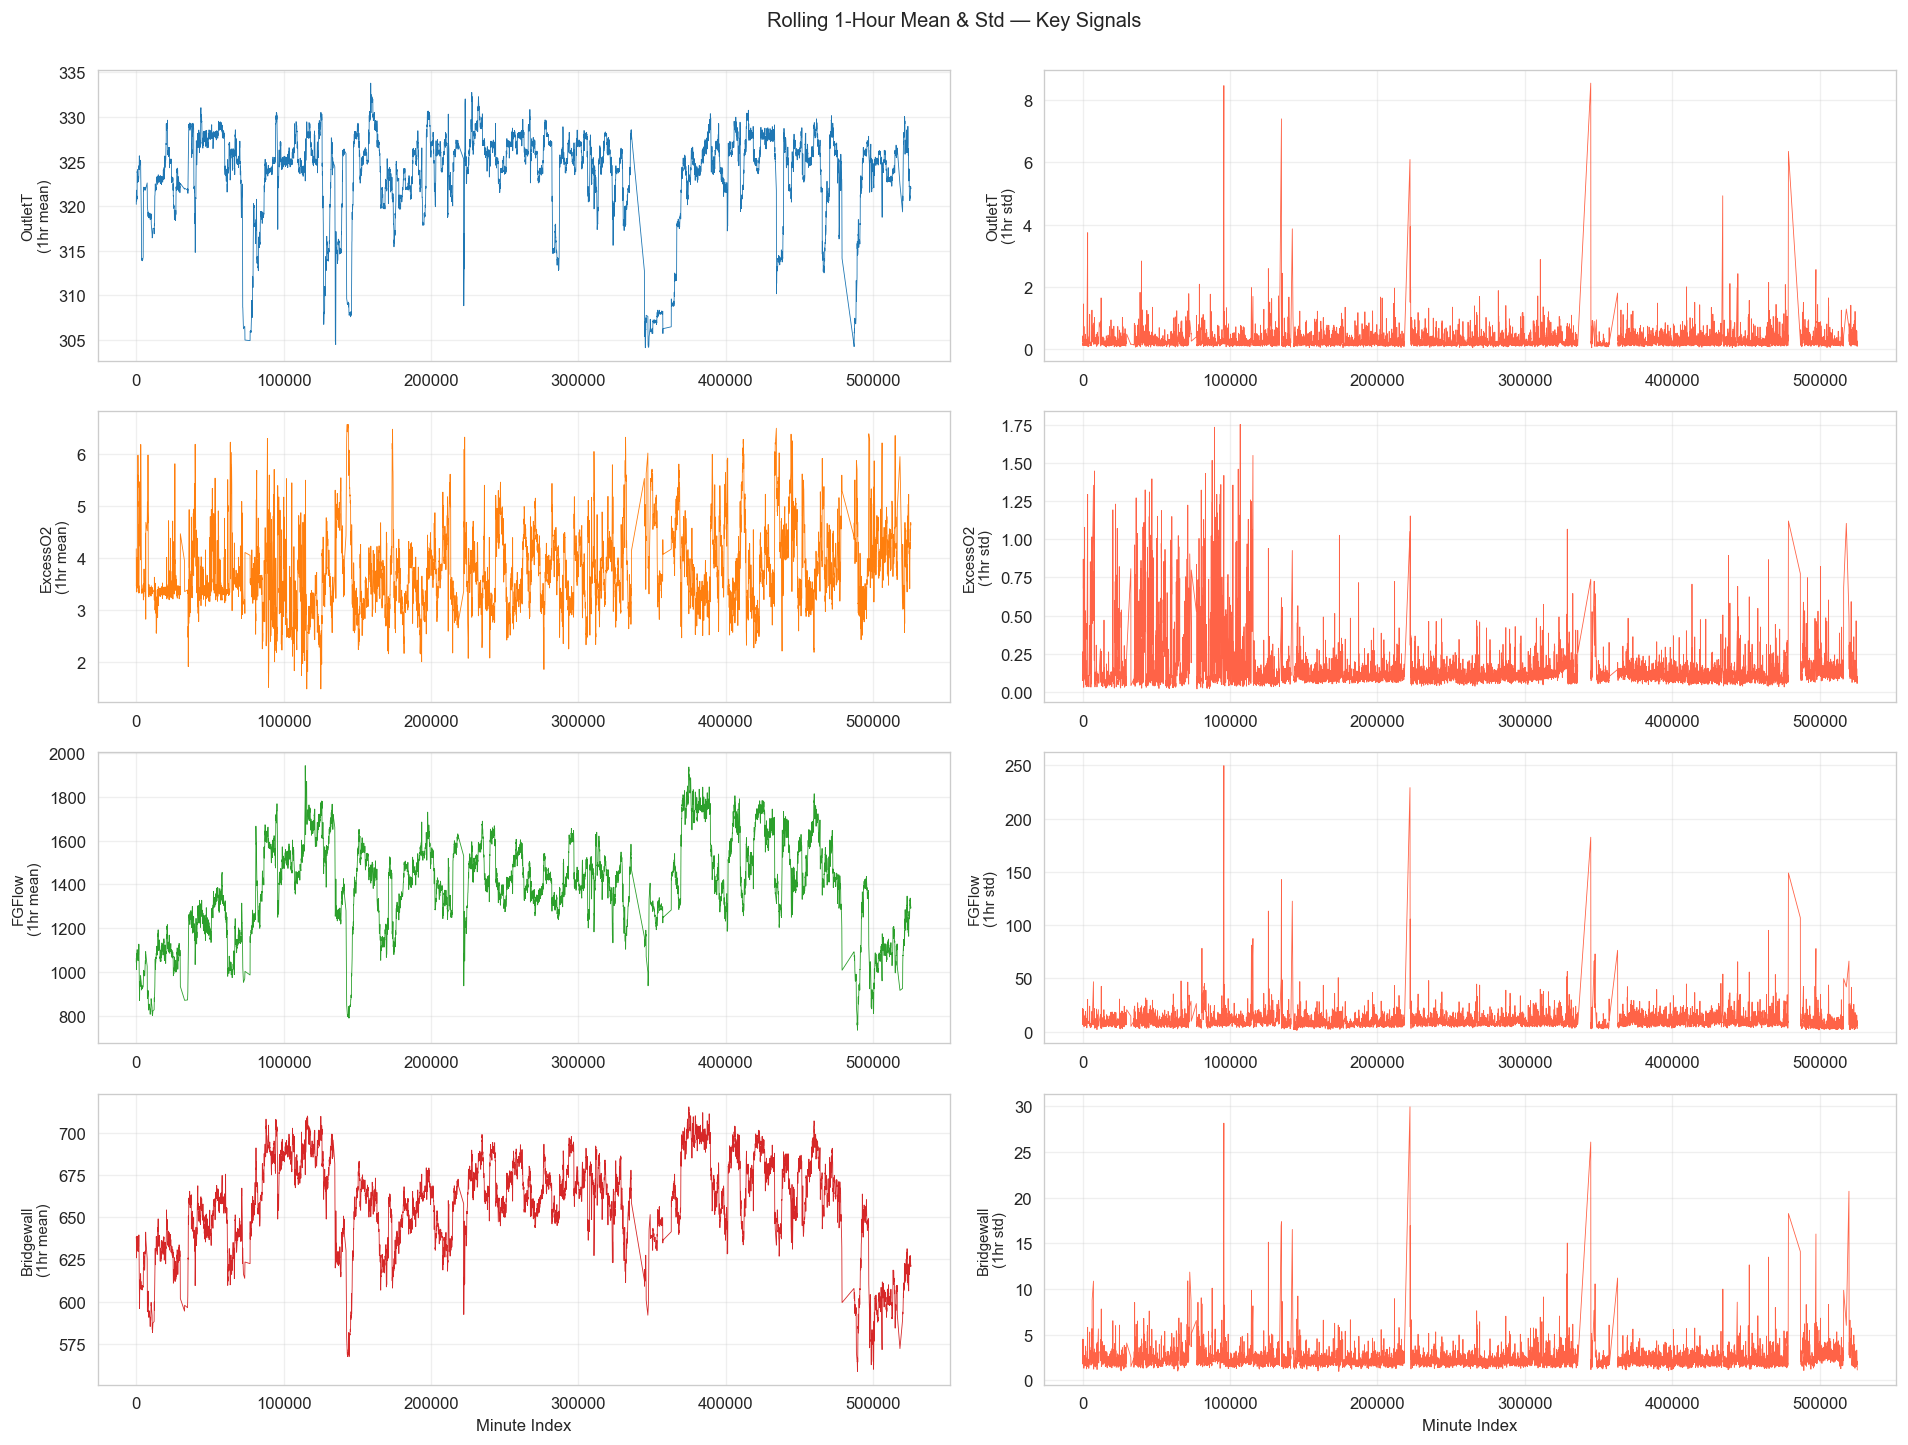

In [7]:
key_signals = ['OutletT', 'ExcessO2', 'FGFlow', 'Bridgewall']
window = 60  # 1 hour

fig, axes = plt.subplots(len(key_signals), 2, figsize=(16, 3 * len(key_signals)))

for i, col in enumerate(key_signals):
    s = df[col]
    roll_mean = s.rolling(window, min_periods=1).mean()
    roll_std  = s.rolling(window, min_periods=1).std()

    # Downsample for plotting
    idx = df['Date'].values[::60]
    rm = roll_mean.values[::60]
    rs = roll_std.values[::60]

    axes[i, 0].plot(idx, rm, color=colors[i], linewidth=0.5)
    axes[i, 0].set_ylabel(f'{col}\n(1hr mean)', fontsize=9)
    axes[i, 0].grid(True, alpha=0.3)

    axes[i, 1].plot(idx, rs, color='tomato', linewidth=0.5)
    axes[i, 1].set_ylabel(f'{col}\n(1hr std)', fontsize=9)
    axes[i, 1].grid(True, alpha=0.3)

axes[-1, 0].set_xlabel('Minute Index')
axes[-1, 1].set_xlabel('Minute Index')
fig.suptitle('Rolling 1-Hour Mean & Std — Key Signals', fontsize=12, y=1.0)
plt.tight_layout()
plt.savefig('plots/eda_rolling_stats.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Key Scatter Plots

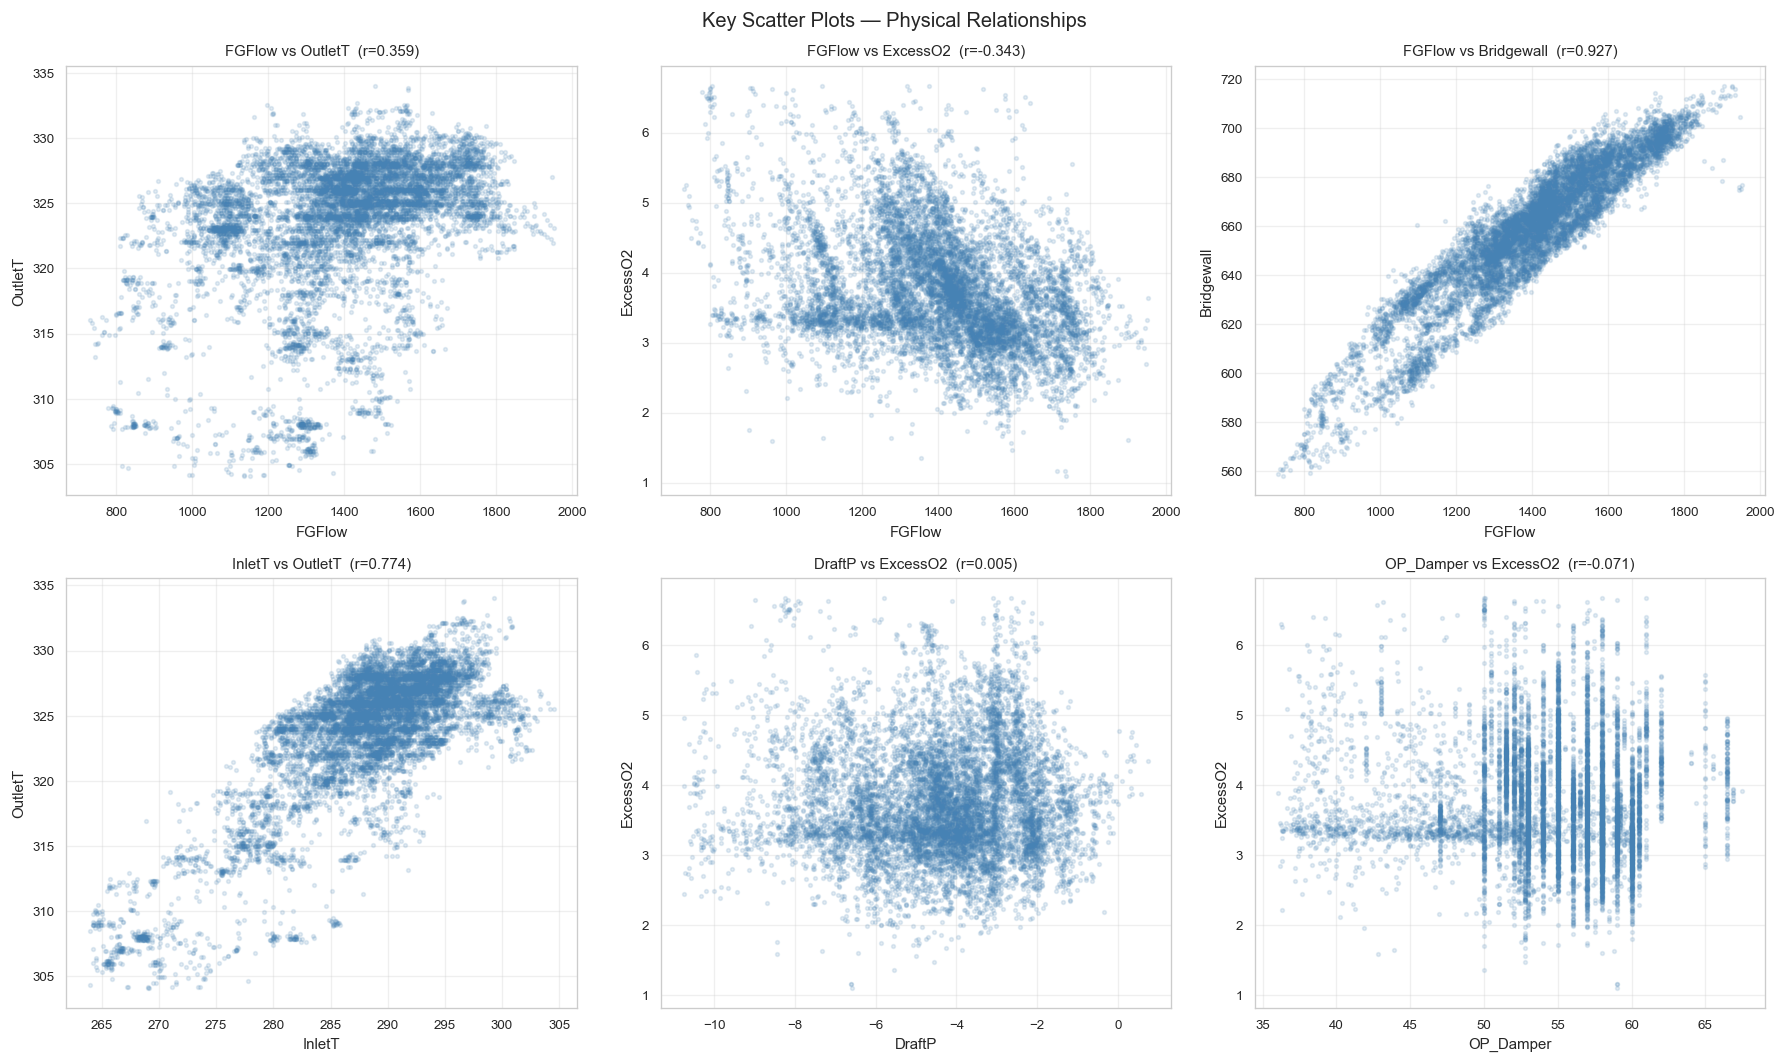

In [8]:
pairs = [
    ('FGFlow', 'OutletT'),
    ('FGFlow', 'ExcessO2'),
    ('FGFlow', 'Bridgewall'),
    ('InletT', 'OutletT'),
    ('DraftP', 'ExcessO2'),
    ('OP_Damper', 'ExcessO2'),
]

fig, axes = plt.subplots(2, 3, figsize=(15, 9))
axes = axes.ravel()

# Use a subsample for scatter (full dataset too dense)
sample = df.sample(n=min(10000, len(df)), random_state=42)

for i, (x_col, y_col) in enumerate(pairs):
    ax = axes[i]
    ax.scatter(sample[x_col], sample[y_col], alpha=0.15, s=5, c='steelblue')
    r = df[x_col].corr(df[y_col])
    ax.set_xlabel(x_col, fontsize=9)
    ax.set_ylabel(y_col, fontsize=9)
    ax.set_title(f'{x_col} vs {y_col}  (r={r:.3f})', fontsize=9)
    ax.tick_params(labelsize=8)
    ax.grid(True, alpha=0.3)

fig.suptitle('Key Scatter Plots — Physical Relationships', fontsize=12)
plt.tight_layout()
plt.savefig('plots/eda_scatter_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Contiguous Block Analysis

Total contiguous blocks: 541
Longest: 92,431 min (64.2 days)
Median:  7 min
Blocks ≥ 30 min:   141
Blocks ≥ 240 min:  68
Blocks ≥ 1440 min: 31

Data in blocks ≥ 30 min: 467,910 rows (99.4%)


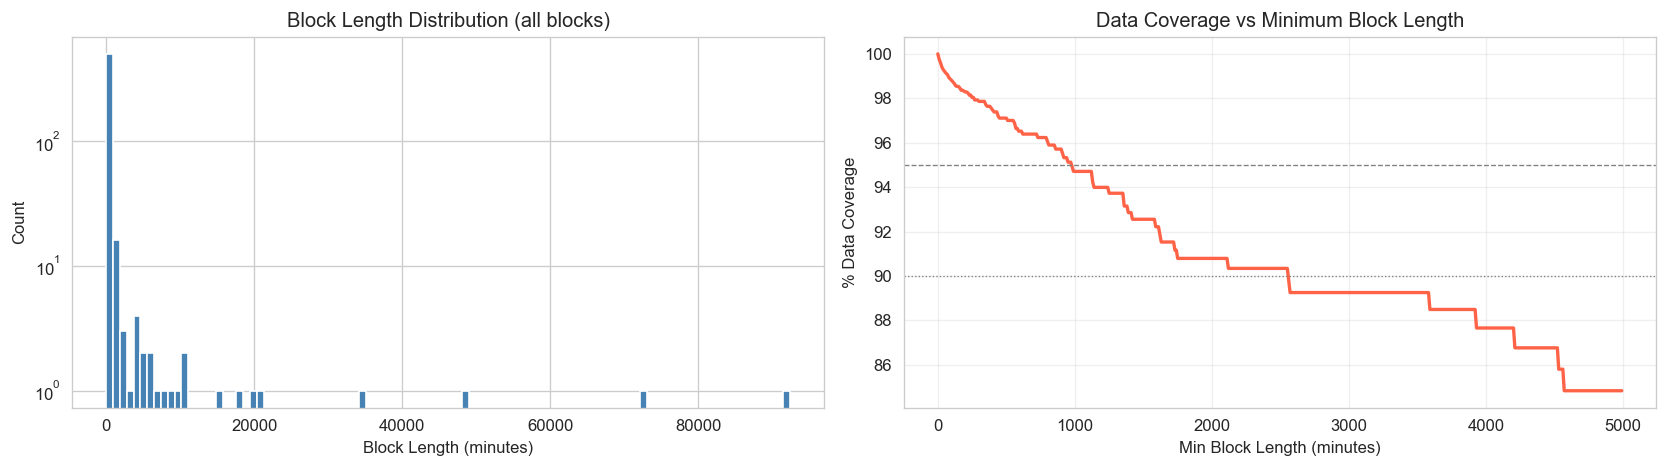

In [9]:
date_diff = df['Date'].diff()
block_break = date_diff > 1
block_id = block_break.cumsum()
block_sizes = block_id.value_counts().sort_index()

print(f'Total contiguous blocks: {len(block_sizes)}')
print(f'Longest: {block_sizes.max():,} min ({block_sizes.max()/1440:.1f} days)')
print(f'Median:  {int(block_sizes.median())} min')
print(f'Blocks ≥ 30 min:   {(block_sizes >= 30).sum()}')
print(f'Blocks ≥ 240 min:  {(block_sizes >= 240).sum()}')
print(f'Blocks ≥ 1440 min: {(block_sizes >= 1440).sum()}')
print(f'\nData in blocks ≥ 30 min: {block_sizes[block_sizes >= 30].sum():,} rows '
      f'({block_sizes[block_sizes >= 30].sum()/len(df)*100:.1f}%)')

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Full distribution
axes[0].hist(block_sizes.values, bins=100, color='steelblue', edgecolor='white')
axes[0].set_xlabel('Block Length (minutes)')
axes[0].set_ylabel('Count')
axes[0].set_title('Block Length Distribution (all blocks)')
axes[0].set_yscale('log')

# CDF of data coverage by block size threshold
thresholds = np.arange(1, 5000, 10)
coverage = [block_sizes[block_sizes >= t].sum() / len(df) * 100 for t in thresholds]
axes[1].plot(thresholds, coverage, color='tomato', linewidth=2)
axes[1].axhline(95, color='grey', linestyle='--', linewidth=0.8)
axes[1].axhline(90, color='grey', linestyle=':', linewidth=0.8)
axes[1].set_xlabel('Min Block Length (minutes)')
axes[1].set_ylabel('% Data Coverage')
axes[1].set_title('Data Coverage vs Minimum Block Length')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/eda_block_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Summary

**Key findings to check:**
- Are distributions roughly unimodal? (bimodal = hidden operating modes)
- Do correlations match physics? (FGFlow↔OutletT positive, DraftP↔ExcessO2 correlated)
- Rolling std stable? (drift = calibration issue)
- How much data is in blocks ≥ 30 min? (minimum usable for CfC sequences)
- Any remaining artefacts in scatter plots?